<a href="https://colab.research.google.com/github/ShengHangNB/Datasets/blob/master/ML_Assignment2_decision_tree_c4_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Assignment 2**

Implementation of algorithm - Decision Tree C4.5




In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [265]:
# df = pd.read_csv("https://raw.githubusercontent.com/ShengHangNB/Datasets/master/transfusion.csv")
df = pd.read_csv("https://raw.githubusercontent.com/ShengHangNB/Datasets/master/iris.csv")
# df = df.sample(n=150,random_state=123,axis=0)
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [266]:
# check whether there are some duplicated values in the datasets
df.duplicated().sum()

# The results show they are 215 duplicated samples in the datasets,
# I do not drop the duplicated values here because I want to 
# design the function in the algorithm to deal with the duplicated values.

3

In [267]:
# check whether thare are some null values for each attribute
df.isnull().any()

sepal length    False
sepal width     False
petal length    False
petal width     False
class           False
dtype: bool

In [268]:
# check the data type and non-null count values for each attribute
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [269]:
# Table of statistics for all numerical attributes:
df.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [270]:
# get the attributes by using the df.keys() functions,
# then extract all the attributes except for the target name by using the slice method df.keys()[:-1]
attrs = df.keys()[:-1]
print("The attrbutes are: ")
for attr in attrs:
  print(attr)

print("\nThe target is ",df.keys()[-1])

The attrbutes are: 
sepal length
sepal width
petal length
petal width

The target is  class


In [271]:
# split the datasets into the attributes datasets (input) and target datasets (output)
# X: DataFrame type   y: Series type
print("The number of samples in the total datasets are {}\n".format(df.shape[0]))
X = df[attrs]
y = df.iloc[:,-1]

# For the features datasets,target datasets, split them into the training datasets and testing datasets respectively
# The training datasets accounts for 67% of the total datasets,
# The testing datasets acoounts for 33% of the total datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,random_state = 48)


print("The number of samples in the training datasets are {}".format(X_train.shape[0]))
print("The number of samples in the testing datasets are {}".format(X_test.shape[0]))

The number of samples in the total datasets are 150

The number of samples in the training datasets are 100
The number of samples in the testing datasets are 50


In [272]:
def get_split_pointSet(attr_series):
    '''
      功能:通过二分法将连续属性离散化处理
      array: 传入的一列属性的值，series类型
      返回值：所有划分点的集合,array类型
    '''
    unique_values = np.unique(attr_series)
    result = np.array([(unique_values[i] + unique_values[i+1]) / 2 for i in range(len(unique_values)-1)])

    return np.unique(result)

In [273]:
def get_discrete_variables(X,attr,split_point):
  '''
    功能：将连续型变量通过分裂点转换为大于分裂点和小于分离点的离散型变量
    X: 传入的数据集, DataFrame
    attr: 需要分割的属性
    split_point：划分点/分割点
  '''
  bins_to_cut = [min(X[attr]),split_point,max(X[attr])]
  labels_to_cut = [attr + ' < ' + str(split_point), attr + ' > ' + str(split_point)]
  categorized_column = pd.cut(X[attr], bins= bins_to_cut , labels = labels_to_cut, include_lowest=True)
  return categorized_column


In [274]:
def compute_entropy(y):
    '''
      功能：计算信息熵H(D)
      y: 传入的目标值series
      返回值：float类型的计算结果
    '''
    if len(y) < 2:
        return 0.0
    
    freq = y.value_counts(normalize=True)
    
    return -(freq * np.log2(freq + 1e-6)).sum()

In [275]:
def compute_info_gain_ratio(X,y,attr,split_point_list):
    '''
        计算连续型变量中特定属性的单个分裂点的信息增益
        
        X：包含属性的数据集, DataFrame类型
        y：包含目标值的数据集, Series类型
        attr: 要计算信息增益的属性，字符串类型
        split_point_lst: 分割点，float类型
        
        返回值：信息增益率计算结果，float类型; 最优划分点：float类型
        
    '''
    # print("{}'s splited points' list：{}".format(attr,split_point_list))

    best_split_point = 0.0
    best_info_gain = 0.0
    split_entropy = 0.0
    if len(split_point_list) == 0:
      return 0, None

    else:
      for split_point in split_point_list:
          lower_index_boolean = X[attr] < split_point
          lower_X = X[lower_index_boolean]
          lower_y = y[lower_index_boolean]
          
          upper_index_boolean = X[attr] > split_point
          upper_X = X[upper_index_boolean]
          upper_y = y[upper_index_boolean]
          
          Ent_D = compute_entropy(y)
          
          lower_p = len(lower_X) / len(X)
          upper_p = len(upper_X ) / len(X)

          lower_result = lower_p * compute_entropy(lower_y)
          upper_result = upper_p * compute_entropy(upper_y)   
          
          info_gain = Ent_D - (lower_result + upper_result)

          categorized_column = get_discrete_variables(X,attr,split_point)

          split_entropy = compute_entropy(categorized_column)

          if info_gain > best_info_gain:
              best_info_gain = info_gain
              best_split_point = split_point
            
      info_gain_ratio = best_info_gain / split_entropy

      return info_gain_ratio, best_split_point

In [276]:
class TreeNode:
  def __init__(self,node_name="",default_decision=None):
    self.children = {}
    self.split_point = 0.0
    self.name = node_name
    self.split_attr = None
    self.default_decision = default_decision
    self.decision = None

  def pretty_print(self,prefix=''):
    if self.split_attr is not None:
      for k,v in self.children.items():
        v.pretty_print(f"{prefix}: When {self.split_attr} is {k}")
    else:
      print(f"{prefix}:{self.decision}")

  def make(self,X,y):
    if self.default_decision is None:
      self.default_decision = y.mode()[0]

    # print("Node name of this sub datasets: ",self.name)
    # print("Input values:")
    # print(X)
    # print("\nTarget values:")
    # print(y)

    if len(X) == 0:
      self.decision = self.default_decision
      # print("Specially determining the decision ->", self.decision)
      # print("------------------------------------------------------------------------------------------------------------")
      return

    else:
      target_unique_values = y.unique()
      if len(target_unique_values) == 1:
        self.decision = target_unique_values[0]
        # print("Determining the decision ->", self.decision)
        # print("------------------------------------------------------------------------------------------------------------")
        return

      else:
        max_infoGain_rate = 0.0
        best_split_point = 0.0
        best_split_point_list = []
        # print()
        for attr in X.keys():
          split_point_list = get_split_pointSet(X[attr])
          if len(split_point_list) == 0:
            # No split point here, which means that this attritbue has only one type of value
            continue

          else:
            infoGain_rate,splited_point = compute_info_gain_ratio(X,y,attr,split_point_list)
            if infoGain_rate > max_infoGain_rate:
              max_infoGain_rate = infoGain_rate
              self.split_attr = attr
              best_split_point_list = split_point_list
              best_split_point = splited_point

        self.split_point = best_split_point

        if self.split_point != 0.0:

          X_copy = X.copy()
          discrete_class = self.split_attr + '-group'
          X_copy.loc[:,discrete_class] = get_discrete_variables(X_copy,self.split_attr,self.split_point)
          # print("\nSplited by {} attribute，its information gain ratio：{}".format(self.split_attr,max_infoGain_rate)) 
          
          for value in X_copy[discrete_class].unique():
            index_boolean = X_copy[discrete_class] == value
            self.children[value] = TreeNode(node_name = value, default_decision=self.default_decision)
            
            # print("{}'s splited points' list：{}".format(self.split_attr,best_split_point_list))
            # print("Still can't determine the decision, child's node is split below:")
            self.children[value].make(X[index_boolean],y[index_boolean])
        
        else:
          # print('All attributes have no information gain (ratio)')
          y_mode = y.mode()

          if len(y_mode) == 1:
            better_decision = y_mode[0]
            # print("Choosing the better decision ->",better_decision)
            # print("------------------------------------------------------------------------------------------------------------")
            self.decision = better_decision

          else:
            decision = y_mode[0]
            # print("Can not choose the better decision, these two samples have the sample inputs but different output")
            # print("Just Choose the decision ->",decision)
            # print("------------------------------------------------------------------------------------------------------------")
            self.decision = decision
          return


In [277]:
class TreeC4_5:
  def __init__(self):
    self.root = None

  def fit(self,X,y):
    self.root = TreeNode()
    self.root.make(X,y)

  def predict(self,samples):
    decision_list = []
    for sample_index in range(len(samples)):
      sample = samples.iloc[sample_index]
      decision = self.make_decision(sample) 
      decision_list.append(decision)
    return np.array(decision_list)

  def make_decision(self,sample):
    current_node = self.root
    while current_node.decision is None:
      attribute_to_split = current_node.split_attr
      attribute_value = sample[attribute_to_split]
      # print("Testing: ",attribute_to_split,"->",attribute_value)
      
      if attribute_value > current_node.split_point:
        next_attr = current_node.split_attr + ' > ' + str(current_node.split_point)
      
      else:
        next_attr = current_node.split_attr + ' < ' + str(current_node.split_point)
          
      current_node = current_node.children[next_attr]

    # print("Decision-> {}\n".format(current_node.decision))
    return current_node.decision

In [278]:
dt4_5 = TreeC4_5()
dt4_5.fit(X_train,y_train)

In [279]:
dt4_5.root.pretty_print('Details of splited node')

Details of splited node: When petal length is petal length < 2.45:Iris-setosa
Details of splited node: When petal length is petal length > 2.45: When petal length is petal length < 4.85: When petal width is petal width < 1.65:Iris-versicolor
Details of splited node: When petal length is petal length > 2.45: When petal length is petal length < 4.85: When petal width is petal width > 1.65:Iris-virginica
Details of splited node: When petal length is petal length > 2.45: When petal length is petal length > 4.85: When petal length is petal length < 5.15: When petal width is petal width > 1.7000000000000002:Iris-virginica
Details of splited node: When petal length is petal length > 2.45: When petal length is petal length > 4.85: When petal length is petal length < 5.15: When petal width is petal width < 1.7000000000000002: When sepal length is sepal length < 6.6: When petal width is petal width < 1.55:Iris-virginica
Details of splited node: When petal length is petal length > 2.45: When peta

In [280]:
decisions = dt4_5.predict(X_test)
results = decisions == y_test
accuracy = sum(results) / len(results)
print("Accuracy: ", accuracy)

Accuracy:  0.96


In [286]:
in_errs = []
out_errs = []
train_size = 0.3
for random_seed in range(10):
    # Randomly split training/test data
    X_trn, X_val, y_trn, y_val = train_test_split(
        X, y, train_size=train_size, random_state=random_seed)
    
    # Re-make a data model in each experiment
    dt = TreeC4_5()
    dt.fit(X_trn, y_trn) 
    
    # append the in/out error rates to the corresponding book-keeping
    in_sample_error_rate = np.sum((dt.predict(X_trn) != y_trn)) / len(y_trn)
    out_sample_error_rate = np.sum((dt.predict(X_val) != y_val)) / len(y_trn)
    # arrays
    # in_errs.append("Insert your code here")
    in_errs.append(in_sample_error_rate)
    # out_errs.append("Insert your code here")
    out_errs.append(out_sample_error_rate)

in_errs = np.array(in_errs)
out_errs = np.array(out_errs)
print(f"in_errs: mean {in_errs.mean():.2f}, std {in_errs.std():.2f}")
print(f"out_errs: mean {out_errs.mean():.2f}, std {out_errs.std():.2f}")

in_errs: mean 0.00, std 0.00
out_errs: mean 0.16, std 0.07


In [287]:
from sklearn import tree 
import graphviz   

clf = tree.DecisionTreeClassifier(criterion="entropy",random_state=35)
clf = clf.fit(X_train,y_train)

In [288]:
decisions = clf.predict(X_test)
result = [decision == target for decision,target in zip(decisions,y_test)]
accuracy = sum(result)/len(result)
print('Accuracy:',accuracy)

Accuracy: 0.94


In [289]:
in_errs = []
out_errs = []
train_size = 0.3
for random_seed in range(10):
    # Randomly split training/test data
    X_trn, X_val, y_trn, y_val = train_test_split(
        X, y, train_size=train_size, random_state=random_seed)
    
    # Re-make a data model in each experiment
    dt = tree.DecisionTreeClassifier(criterion="entropy")
    dt.fit(X_trn, y_trn) 
    
    # append the in/out error rates to the corresponding book-keeping
    in_sample_error_rate = np.sum((dt.predict(X_trn) != y_trn)) / len(y_trn)
    out_sample_error_rate = np.sum((dt.predict(X_val) != y_val)) / len(y_trn)
    # arrays
    # in_errs.append("Insert your code here")
    in_errs.append(in_sample_error_rate)
    # out_errs.append("Insert your code here")
    out_errs.append(out_sample_error_rate)

in_errs = np.array(in_errs)
out_errs = np.array(out_errs)
print(f"in_errs: mean {in_errs.mean():.2f}, std {in_errs.std():.2f}")
print(f"out_errs: mean {out_errs.mean():.2f}, std {out_errs.std():.2f}")

in_errs: mean 0.00, std 0.00
out_errs: mean 0.12, std 0.03


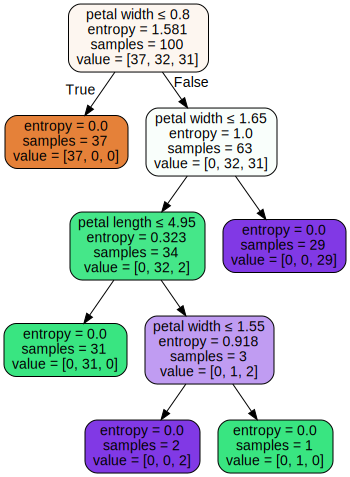

In [290]:
dot_data = tree.export_graphviz(clf,out_file=None,feature_names=list(X_train.columns.values),filled=True,rounded=True,special_characters=True)
graphOfTree = graphviz.Source(dot_data)
graphOfTree